<a href="https://colab.research.google.com/github/abhinav9629/Point-E-Image-to-3D/blob/main/PointE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install plotly -q

In [8]:
!git clone https://github.com/openai/point-e.git

Cloning into 'point-e'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 57 (delta 7), reused 51 (delta 7), pack-reused 0
Unpacking objects: 100% (57/57), 1.56 MiB | 7.06 MiB/s, done.


In [9]:
%cd point-e

/content/point-e/point-e


In [ ]:
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/point-e/point-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-ztr925tm/clip_73d33d20ecb14cdb8041a3a289d52573
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-ztr925tm/clip_73d33d20ecb14cdb8041a3a289d52573
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Attempting uninstall: point-e
    Found existing installation: point-e 0.0.0
    Uninstalling point-e-0.0.0:
      Successfully uninstalled point-e-0.0.0
  Running setup.py develop for point-e


In [ ]:
from PIL import Image
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base300M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


/usr/local/lib/python3.10/dist-packages/clip/clip.py:57: UserWarning: /content/point-e/point_e_model_cache/ViT-L-14.pt exists, but the SHA256 checksum does not match; re-downloading the file
  warnings.warn(f"{download_target} exists, but the SHA256 checksum does not match; re-downloading the file")
100%|████████████████████████████████████████| 890M/890M [00:08<00:00, 116MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/1.25G [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [15]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [60]:
# Load an image to condition on.
# img = Image.open('/content/point-e/Images/car.png')
img = Image.open('/content/point-e/Images/conejpg.jpg')

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x

0it [00:00, ?it/s]

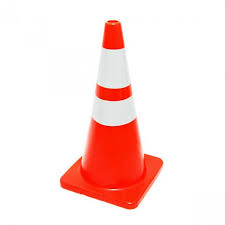

In [61]:
img.show()

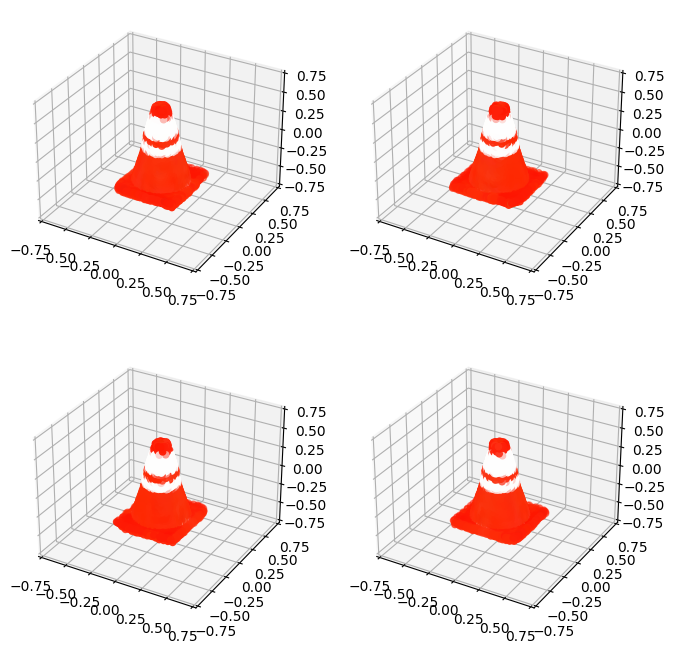

In [62]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=2, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [63]:
pc.coords

array([[ 0.2762146 ,  0.02789415, -0.48176622],
       [ 0.03082037, -0.23830427, -0.4617909 ],
       [ 0.05628815,  0.23694056, -0.4996433 ],
       ...,
       [ 0.05503244, -0.04592509,  0.12414593],
       [-0.02942866, -0.19462357, -0.4859883 ],
       [ 0.14187516, -0.00117812,  0.02414848]], dtype=float32)

In [64]:
import pandas as pd
import plotly.express as px

In [65]:
df = pd.DataFrame(pc.coords,columns = ['x','y','z'])

In [66]:
df.head()

,x,y,z
0,0.276215,0.027894,-0.481766
1,0.030820,-0.238304,-0.461791
2,0.056288,0.236941,-0.499643
3,0.214945,-0.028723,-0.350523
4,-0.133927,-0.040367,0.018464


In [67]:
fig3d = px.scatter_3d(df, x='x', y='y', z='z')
fig3d.show()